In [3]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy
from scipy.stats import entropy
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit

In [27]:
dataset_path_1st="1st_test"
dataset_path_2nd="2nd_test"
dataset_path_3rd="3rd_test/4th_test/txt"

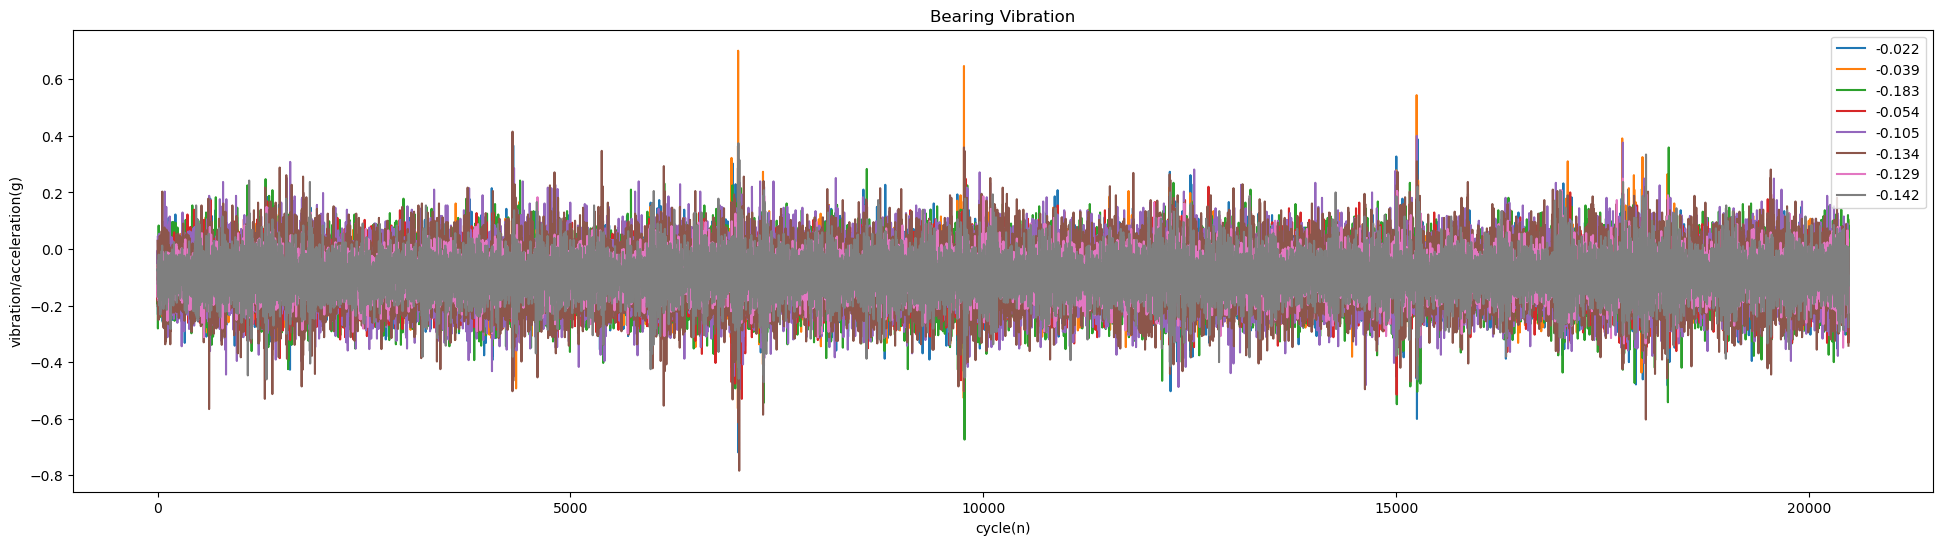

In [16]:
dataset=pd.read_csv('1st_test/2003.10.22.12.06.24',sep='\t')
ax=dataset.plot(figsize=(24,6),title="Bearing Vibration",legend=True)
ax.set(xlabel='cycle(n)',ylabel="vibration/acceleration(g)")
plt.show()

In [17]:
dataset.head()

,-0.022,-0.039,-0.183,-0.054,-0.105,-0.134,-0.129,-0.142
0,-0.105,-0.017,-0.164,-0.183,-0.049,0.029,-0.115,-0.122
1,-0.183,-0.098,-0.195,-0.125,-0.005,-0.007,-0.171,-0.071
2,-0.178,-0.161,-0.159,-0.178,-0.100,-0.115,-0.112,-0.078
3,-0.208,-0.129,-0.261,-0.098,-0.151,-0.205,-0.063,-0.066
4,-0.232,-0.061,-0.281,-0.125,0.046,-0.088,-0.078,-0.078


In this section several signal-based statistical features has been extracted from the data                                 
**Definition and formula of the features:**
* ***Absolute Mean*** $$\overline{x} = \frac{1}{N}\sum_{i=1}^{N}|x_i| $$

* ***Standart Deviation:*** $$\sigma         = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(x_i - \overline{x})^2}$$
* ***Skewness:*** 
Asymmetry of a signal distribution. Faults can impact distribution symmetry and therefore increase the level of skewness.
$$\mathrm{Sk} = \frac{1}{N}\sum_{i=1}^{N}\frac{(x_i-\overline{x})^3}{\sigma^3}$$
* ***Kurtosis:***
Length of the tails of a signal distribution, or equivalently, how outlier prone the signal is. Developing faults can increase the number of outliers, and therefore increase the value of the kurtosis metric.
$$\mathrm{K} = \frac{1}{N}\sum_{i=1}^{N}\frac{(x_i-\overline{x})^4}{\sigma^4}$$
* ***Entropy:***$$ H(X) = -\sum_{i=1}^{N} P(x_i)\log{P(x_i)} $$
                            
* ***RMS:*** $$x_{rms} =\sqrt{(\frac{1}{N})\sum_{i=1}^{N}(x)^{2}}$$

* ***Peak to Peak:*** $$ x_p = \max \mathrm{value} - \min \mathrm{value}$$

* ***Crest Factor:*** 
Peak value divided by the RMS. Faults often first manifest themselves in changes in the peakiness of a signal before they manifest in the energy represented by the signal root mean squared. The crest factor can provide an early warning for faults when they first develop. 
$$x_{crest} =\frac{\max \mathrm{value}}{\mathrm{x_{rms}}}$$

* ***Clearence Factor:*** 
Peak value divided by the squared mean value of the square roots of the absolute amplitudes. For rotating machinery, this feature is maximum for healthy bearings and goes on decreasing for defective ball, defective outer race, and defective inner race respectively. The clearance factor has the highest separation ability for defective inner race faults.
$$ x_{clear} = \frac{x_p}{(\frac{1}{N}\sum_{i=1}^{N}\sqrt{|x_i|})^2}  $$

* ***Shape Factor:*** 
RMS divided by the mean of the absolute value. Shape factor is dependent on the signal shape while being independent of the signal dimensions.
$$\frac{x_{rms}}{\overline{x}}$$

* ***Impulse:*** 
Compare the height of a peak to the mean level of the signal.
$$\frac{\max \mathrm{value}}{\overline{x}}  $$

In [44]:
#Root Mean Squared Sum
def calculate_rms(df):
    result=[]
    for col in df:
        r=np.sqrt((df[col]**2).sum()/len(df[col]))
        result.append(r)
    return result


#extract peak to peak features
def calculate_p2p(df):
    return np.array(df.max().abs()+df.min().abs())

#extract shanon entropy
def calculate_entropy(df):
    ent=[]
    for col in df:
        ent.append(entropy(pd.cut(df[col],500).value_counts()))
    return np.array(ent)


#extract clearance factor
def calculate_clearance(df):
    result=[]
    for col in df:
        r=((np.sqrt(df[col].abs())).sum()/len(df[col]))**2
        result.append(r)
    return result

def time_features(dataset_path,id_set=None):
    time_features=['mean','std','skew','kurtosis','entropy','rms','max','p2p','crest','clearance','shape','Impulse']
    cols1=['B1_x','B1_y','B2_x','B2_y','B3_x','B3_y','B4_x','B4_y']
    cols2=['B1','B2','B3','B4']


#initialize
    if id_set==1:
        columns=[c+'_'+tf for c in cols1 for tf in time_features]
        data=pd.DataFrame(columns=columns)
    else:
        columns=[c+'_'+tf for c in cols2 for tf in time_features]
        data=pd.DataFrame(columns=columns)


    for filename in os.listdir(dataset_path):
        raw_data=pd.read_csv(os.path.join(dataset_path,filename),sep='\t')
        #print(os.path.join(dataset_path,filename))

        #time features
        mean_abs=np.array(raw_data.abs().mean())
        std=np.array(raw_data.std())
        skew=np.array(raw_data.skew())
        kurtosis=np.array(raw_data.kurtosis())
        entropy=calculate_entropy(raw_data)
        rms=np.array(calculate_rms(raw_data))
        max_abs=np.array(raw_data.abs().max())
        p2p=calculate_p2p(raw_data)
        crest=max_abs/rms
        clearance=np.array(calculate_clearance(raw_data))
        shape=rms/mean_abs
        impulse=max_abs/mean_abs

        if id_set==1:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,8), columns=[c+'_mean' for c in cols1])
            std = pd.DataFrame(std.reshape(1,8), columns=[c+'_std' for c in cols1])
            skew = pd.DataFrame(skew.reshape(1,8), columns=[c+'_skew' for c in cols1])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,8), columns=[c+'_kurtosis' for c in cols1])
            entropy = pd.DataFrame(entropy.reshape(1,8), columns=[c+'_entropy' for c in cols1])
            rms = pd.DataFrame(rms.reshape(1,8), columns=[c+'_rms' for c in cols1])
            max_abs = pd.DataFrame(max_abs.reshape(1,8), columns=[c+'_max' for c in cols1])
            p2p = pd.DataFrame(p2p.reshape(1,8), columns=[c+'_p2p' for c in cols1])
            crest = pd.DataFrame(crest.reshape(1,8), columns=[c+'_crest' for c in cols1])
            clearance = pd.DataFrame(clearance.reshape(1,8), columns=[c+'_clearence' for c in cols1])
            shape = pd.DataFrame(shape.reshape(1,8), columns=[c+'_shape' for c in cols1])
            impulse = pd.DataFrame(impulse.reshape(1,8), columns=[c+'_impulse' for c in cols1])

        else:
            
            mean_abs = pd.DataFrame(mean_abs.reshape(1,8), columns=[c+'_mean' for c in cols1])
            std = pd.DataFrame(std.reshape(1,8), columns=[c+'_std' for c in cols1])
            skew = pd.DataFrame(skew.reshape(1,8), columns=[c+'_skew' for c in cols1])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,8), columns=[c+'_kurtosis' for c in cols1])
            entropy = pd.DataFrame(entropy.reshape(1,8), columns=[c+'_entropy' for c in cols1])
            rms = pd.DataFrame(rms.reshape(1,8), columns=[c+'_rms' for c in cols1])
            max_abs = pd.DataFrame(max_abs.reshape(1,8), columns=[c+'_max' for c in cols1])
            p2p = pd.DataFrame(p2p.reshape(1,8), columns=[c+'_p2p' for c in cols1])
            crest = pd.DataFrame(crest.reshape(1,8), columns=[c+'_crest' for c in cols1])
            clearance = pd.DataFrame(clearance.reshape(1,8), columns=[c+'_clearence' for c in cols1])
            shape = pd.DataFrame(shape.reshape(1,8), columns=[c+'_shape' for c in cols1])
            impulse = pd.DataFrame(impulse.reshape(1,8), columns=[c+'_impulse' for c in cols1])


        mean_abs.index = [filename]
        std.index = [filename]
        skew.index = [filename]
        kurtosis.index = [filename]
        entropy.index = [filename]
        rms.index = [filename]
        max_abs.index = [filename]
        p2p.index = [filename]
        crest.index = [filename]
        clearance.index = [filename]
        shape.index = [filename]
        impulse.index = [filename] 


        merge=pd.concat([mean_abs, std, skew, kurtosis, entropy, rms, max_abs, p2p,crest,clearance, shape, impulse], axis=1)
        data=data.append(merge)


    if id_set==1:
        cols = [c+'_'+tf for c in cols1 for tf in time_features]
        data = data[cols]
    else:
        cols = [c+'_'+tf for c in cols2 for tf in time_features]
        data = data[cols]


    data.index=pd.to_datetime(data.index,format='%Y.%m.%d.%H.%M.%S')
    data=data.sort_index()
    return data


    

Now call the above feature Extraction function

In [45]:
set1=time_features(dataset_path_1st,id_set=1)
set1.to_csv('set1_timefeatures.csv')

C:\Users\BHELDNA\AppData\Local\Temp\ipykernel_31068\688171041.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append(merge)
C:\Users\BHELDNA\AppData\Local\Temp\ipykernel_31068\688171041.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append(merge)
C:\Users\BHELDNA\AppData\Local\Temp\ipykernel_31068\688171041.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append(merge)
C:\Users\BHELDNA\AppData\Local\Temp\ipykernel_31068\688171041.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append(merge)
C:\Users\BHELDNA\AppData\Local\Temp\ipykernel_31068\688171041.py:108: FutureWarning:

In [39]:
set1.head()

,B1_x_mean,B1_x_std,B1_x_skew,B1_x_kurtosis,B1_x_entropy,B1_x_rms,B1_x_max,B1_x_p2p,B1_x_crest,B1_x_clearance,...,B4_y_skew,B4_y_kurtosis,B4_y_entropy,B4_y_rms,B4_y_max,B4_y_p2p,B4_y_crest,B4_y_clearance,B4_y_shape,B4_y_Impulse
2003-10-22 12:06:24,0.104148,0.081124,-0.029900,1.069800,4.803057,0.124617,0.720,1.108,5.777714,NaN,...,0.008208,1.808719,4.690580,0.115266,0.471,0.845,4.086202,NaN,1.158299,NaN
2003-10-22 12:09:13,0.103651,0.079519,-0.070118,1.161960,4.844846,0.123812,0.654,1.042,5.282223,NaN,...,-0.053721,1.873845,4.666142,0.109210,0.627,0.900,5.741234,NaN,1.166936,NaN
2003-10-22 12:14:13,0.105039,0.080220,-0.041579,0.986724,4.889311,0.125249,0.623,0.940,4.974097,NaN,...,0.047069,1.430242,4.681037,0.113695,0.601,0.977,5.286066,NaN,1.156631,NaN
2003-10-22 12:19:13,0.104900,0.080828,0.005235,1.034758,4.852691,0.125200,0.598,1.055,4.776357,NaN,...,0.021169,1.378689,4.696194,0.114415,0.525,0.852,4.588565,NaN,1.160373,NaN
2003-10-22 12:24:13,0.104779,0.082038,-0.060123,1.110658,4.889993,0.125621,0.623,1.011,4.959370,NaN,...,0.008713,1.498303,4.693572,0.114260,0.522,0.871,4.568532,NaN,1.160343,NaN


In [46]:
set1=pd.read_csv("./set1_timefeatures.csv")
set1=set1.rename(columns={'Unnamed: 0':'time'})
last_cycle=int(len(set1))

In [47]:
set1.head()

,time,B1_x_mean,B1_x_std,B1_x_skew,B1_x_kurtosis,B1_x_entropy,B1_x_rms,B1_x_max,B1_x_p2p,B1_x_crest,...,B4_y_skew,B4_y_kurtosis,B4_y_entropy,B4_y_rms,B4_y_max,B4_y_p2p,B4_y_crest,B4_y_clearance,B4_y_shape,B4_y_Impulse
0,2003-10-22 12:06:24,0.104148,0.081124,-0.029900,1.069800,4.803057,0.124617,0.720,1.108,5.777714,...,0.008208,1.808719,4.690580,0.115266,0.471,0.845,4.086202,NaN,1.158299,NaN
1,2003-10-22 12:09:13,0.103651,0.079519,-0.070118,1.161960,4.844846,0.123812,0.654,1.042,5.282223,...,-0.053721,1.873845,4.666142,0.109210,0.627,0.900,5.741234,NaN,1.166936,NaN
2,2003-10-22 12:14:13,0.105039,0.080220,-0.041579,0.986724,4.889311,0.125249,0.623,0.940,4.974097,...,0.047069,1.430242,4.681037,0.113695,0.601,0.977,5.286066,NaN,1.156631,NaN
3,2003-10-22 12:19:13,0.104900,0.080828,0.005235,1.034758,4.852691,0.125200,0.598,1.055,4.776357,...,0.021169,1.378689,4.696194,0.114415,0.525,0.852,4.588565,NaN,1.160373,NaN
4,2003-10-22 12:24:13,0.104779,0.082038,-0.060123,1.110658,4.889993,0.125621,0.623,1.011,4.959370,...,0.008713,1.498303,4.693572,0.114260,0.522,0.871,4.568532,NaN,1.160343,NaN


In [48]:
features=set1.copy()
ma=pd.DataFrame()
ma['B4_x_mean']=features['B4_x_mean']
ma['SMA']=ma['B4_x_mean'].rolling(window=5).mean()
ma['time']=features['time']

<Axes: xlabel='time'>

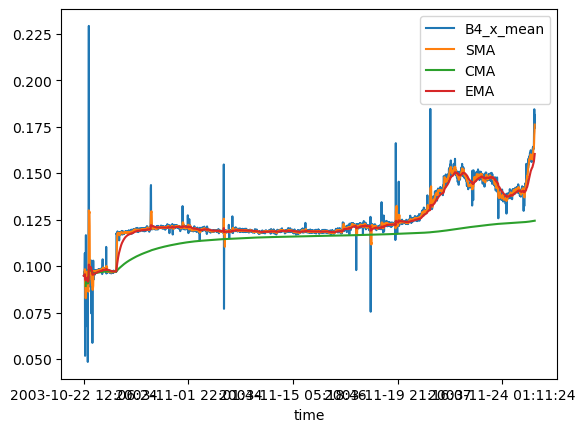

In [49]:
ma['CMA']=ma['B4_x_mean'].expanding(min_periods=10).mean()
ma['EMA']=ma['B4_x_mean'].ewm(span=40,adjust=False).mean()
ma.plot(x='time',y=['B4_x_mean','SMA','CMA','EMA'])

Here we would like to have a single feature that can serve as an indicator for the overall health. Obviously the indication is already there in the features we have captured. Hence a single feature can be built from the exsiting features and the best way to do it is by PCA. PCA simply tries different combination of the existing features and captures the best combination that has the highest variance with minimum features. So lets build a health indicator

### RUL Prediction

In [55]:
def health_indicator(bearing_data,use_filter=False):    
    data = bearing_data.copy()
    if use_filter:
        for ft in data.columns:
            data[ft] = data[ft].ewm(span=40,adjust=False).mean()
    pca = PCA()
    X_pca = pca.fit_transform(data)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    print("Explained variance of Pricincipal Component 1 is:"+str(pca.explained_variance_ratio_[0]))
    health_indicator = np.array(X_pca['PC1'])
    degredation = pd.DataFrame(health_indicator,columns=['PC1'])
    degredation['cycle'] = degredation.index
    degredation['PC1'] = degredation['PC1']-degredation['PC1'].min(axis=0)
    
    return degredation


def fit_exp(df,base=500,print_parameters=False):
    x =np.array(df.cycle)
    x = x[-base:].copy()
    y = np.array(degredation.PC1)
    y = y[-base:].copy()
    def exp_fit(x,a,b):
        y = a*np.exp(abs(b)*x)
        return y
    #initial parameters affect the result
    fit = curve_fit(exp_fit,x,y,p0=[0.01,0.001],maxfev=10000)
    if print_parameters:
        print(fit)
    return fit

def predict(X_df,p):
    x =np.array(X_df.cycle)
    a,b = p[0]
    fit_eq = a*np.exp(abs(b)*x)
    return fit_eq
log = [[],[]]

In [56]:
#variable for incrementing index
prediction_cycle = 600
#variable for keeping intial value
init_cycle = prediction_cycle

In [57]:
#selected_features = ['mean','std','kurtosis','skew','entropy',
#        'rms','max','p2p','crest','shape','impulse']
selected_features = ['max','p2p','rms']

bearing = 3
B_x = ["B{}_x_".format(bearing)+i for i in selected_features]
early_cycles = set1[B_x][:init_cycle]
early_cycles_pca = health_indicator(early_cycles,use_filter=True)

Explained variance of Pricincipal Component 1 is:0.9955862512721826


Explained variance of Pricincipal Component 1 is:0.9955862512721826
0.05059810879043174 2.6972094483156886e-11
failed at136325648048.07675


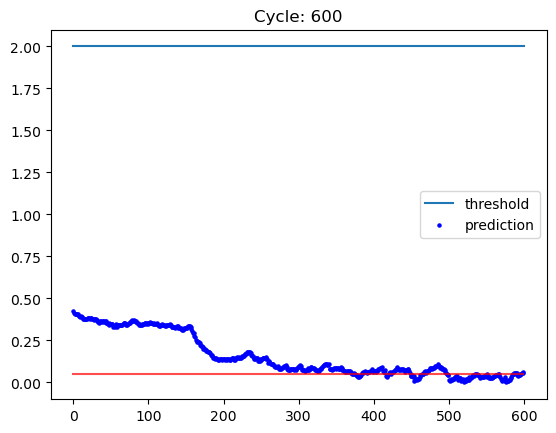

In [58]:
#run this again, again to simulate life-cycle of a bearing
data = set1[B_x][:prediction_cycle]
ind=data.index
degredation = health_indicator(data,use_filter=True)
#degredation.plot(y='PC1',x='cycle')
fit = fit_exp(degredation,base=250)

prediction = predict(degredation,fit)
m,n = fit[0]
thres = 2
#print(prediction_cycle)
fail_cycle = (np.log(thres/m))/abs(n)
log[0].append(prediction_cycle)
log[1].append(fail_cycle)

print(m,n)
print('failed at'+str(fail_cycle))

fig =plt.figure('Cycle: '+str(prediction_cycle))
ax =fig.subplots()

ax.plot([0,prediction_cycle],[2,2])
ax.scatter(degredation['cycle'],degredation['PC1'],color='b',s=5)
ax.plot(degredation['cycle'],prediction,color='r',alpha=0.7)
ax.set_title('Cycle: '+str(prediction_cycle))
ax.legend(['threshold','prediction'])
fig.savefig('output.png')
plt.show()
increment_cycle =25
prediction_cycle += increment_cycle

In [67]:
degradation

NameError: name 'degradation' is not defined